# AS_coordinates test

Kerry N. Wood

kerry.wood@asterism.ai

January 22, 2023

- the `comparing_coordinates` notebook helps us gin up methods for comparison
- once we have that, we move the code into a library `as_coordinates`
- this notebook tests that code and makes it useful for later conversions

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import astropy.coordinates
import astropy.units as u
import astropy.time

import matplotlib.pyplot as plt

import as_coordinates as AS

from load_utils import *
import helpers

In [2]:
init_all()

DllMainInit          : 0
EnvConstDll          : 0
TimeFuncDll          : 0
AstroFuncDll         : 0
TleDll               : 0
SpVecDll             : 0
VcmDll               : 0
ExtEphemDll          : 0
Sgp4PropDll          : 0
ElOpsDll             : 0
SensorDll            : 0
ObsDll               : 0


0

In [3]:
TimeFuncDll.TimeFuncLoadFile( Cstr('./time-constants.dat', 512 ) )

0

In [4]:
N = 10000

test_EPH = np.random.uniform(6500, 55000, size=(N,3) )
test_VEL = np.random.uniform(0, 10, size=(N,3) )
# go from 2000-2025 and randomly sample
test_time  = [  datetime(year=2000,month=1,day=1) + timedelta(days=X) for X in np.random.uniform(0,25*365.25,size=N) ]
astro_date = astropy.time.Time( test_time )
astd_date  = [ helpers.datetime_to_ds50( D, TimeFuncDll ) for D in test_time ]

In [5]:
# convert to TEME and check with AstroPY
astd_teme = [ AS.j2k_to_teme( P,V,D,AstroFuncDll) for P,V,D in zip( test_EPH, test_VEL, astd_date ) ]
astd_teme = np.vstack( [ np.hstack(R) for R in astd_teme ] )

# ------------------------------------  ASTROPY  ------------------------------------
# astropy data
astro_gcrs = astropy.coordinates.GCRS( x = test_EPH[:,0] * u.km,
                                       y = test_EPH[:,1] * u.km,
                                       z = test_EPH[:,2] * u.km,
                                       v_x = test_VEL[:,0] * u.km/u.s,
                                       v_y = test_VEL[:,1] * u.km/u.s,
                                       v_z = test_VEL[:,2] * u.km/u.s,
                                       obstime = astro_date,
                                       representation_type = 'cartesian')
# astropy GCRS to TEME
astro_teme_f = astro_gcrs.transform_to( astropy.coordinates.TEME( obstime=astro_date ) )
astro_teme   = astro_teme_f.cartesian.xyz.to_value(u.km).T

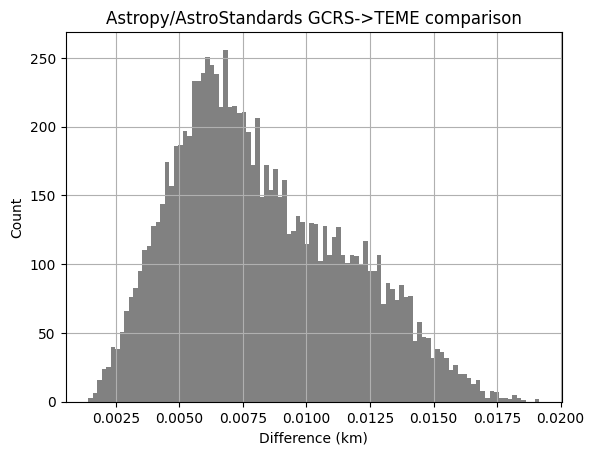

In [6]:
err = astro_teme - astd_teme[:,:3]
plt.close('all')
_ = plt.hist( np.linalg.norm(err, axis=1 ), bins=100, color='#818181')
plt.grid()
plt.xlabel("Difference (km)")
plt.ylabel('Count')
_ = plt.title('Astropy/AstroStandards GCRS->TEME comparison')

In [7]:
LAT, LON, ALT = 0, 0, 0

# setup our times frame
times = AS.setup_times( astd_date, TimeFuncDll )

# now injecft times frame with the eci positions and velocities
targets = times.copy()
targets['teme_p'] = astd_teme[:,:3].tolist()
targets['teme_v'] = astd_teme[:,3:].tolist()

# infer the LLH coordinates (needed for topocomps)
targets = AS.annotate_teme_llh( targets, AstroFuncDll, TimeFuncDll )

# make another times copy for a sensor
sensor = times.copy()
# annotate with LLH info directly
sensor = AS.times_to_llhsensor( times, LAT, LON, ALT, AstroFuncDll, TimeFuncDll )

# now compute some looks
looks = AS.topographic_calcs( sensor, targets, AstroFuncDll)

In [8]:
# now check with astropy
astropy_sen  = astropy.coordinates.EarthLocation( lat=LAT*u.deg, lon=LON*u.deg, height=ALT*u.km, ellipsoid='WGS84')
astropy_look = astro_gcrs.transform_to( astropy.coordinates.AltAz( location=astropy_sen, obstime=astro_gcrs.obstime ) )

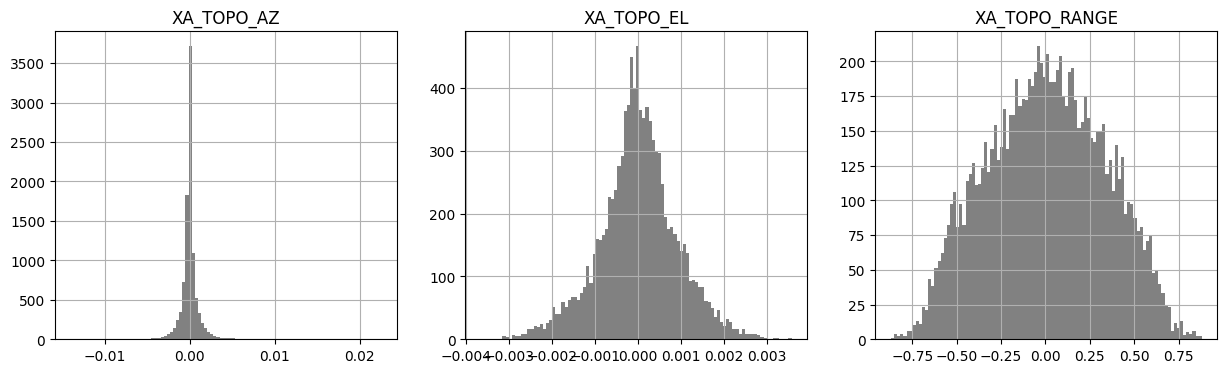

In [9]:
plt.close('all')
f,ax = plt.subplots(1,3,figsize=(15,4))
# avoid numbers like 359...
err = astropy_look.az.to_value(u.deg) - looks['XA_TOPO_AZ']
err = err[ np.abs(err) < 10 ]
_ = ax[0].hist( err, bins=100, color='#818181') 
ax[0].set_title('XA_TOPO_AZ')
_ = ax[1].hist( astropy_look.alt.to_value(u.deg) - looks['XA_TOPO_EL'], bins=100, color='#818181') 
ax[1].set_title('XA_TOPO_EL')
_ = ax[2].hist( astropy_look.distance.to_value(u.km) - looks['XA_TOPO_RANGE'], bins=100, color='#818181') 
ax[2].set_title('XA_TOPO_RANGE')
for a in ax: a.grid()

In [10]:
looks.columns

Index(['ds50_utc_sensor', 'ds50_et_sensor', 'ds50_ut1_sensor',
       'sidereal_sensor', 'lat_sensor', 'lon_sensor', 'alt_sensor',
       'theta_sensor', 'lst_sensor', 'teme_p_sensor', 'teme_v_sensor',
       'ds50_utc_target', 'ds50_et_target', 'ds50_ut1_target',
       'sidereal_target', 'teme_p_target', 'teme_v_target', 'lat_target',
       'lon_target', 'alt_target', 'lst_target', 'XA_TOPO_RA', 'XA_TOPO_DEC',
       'XA_TOPO_AZ', 'XA_TOPO_EL', 'XA_TOPO_RANGE', 'XA_TOPO_RADOT',
       'XA_TOPO_DECDOT', 'XA_TOPO_AZDOT', 'XA_TOPO_ELDOT', 'XA_TOPO_RANGEDOT'],
      dtype='object')

In [27]:
# manually calculate the RA / DEC from the TEME vectors
def calcRADEC( R ):
    lv  = np.array(R['teme_p_target']) - np.array(R['teme_p_sensor'])
    lvn = lv / np.linalg.norm(lv)
    return np.degrees( np.arctan2( lvn[1], lvn[0] ) ), 90-np.degrees( np.arccos( lvn[2] ) )

radec = looks.apply( calcRADEC, axis=1 )
looks['ra'] = [ X[0] for X in radec] 
looks['dec'] = [ X[1] for X in radec] 

def calcRADECDot( R ):
    lv  = np.array(R['teme_v_target']) - np.array(R['teme_v_sensor'])
    return np.degrees( np.arctan2( lv[1], lv[0] ) ), 90-np.degrees( np.arccos( lv[2] / np.linalg.norm(lv) ) )

radec = looks.apply( calcRADECDot, axis=1 )
looks['radot'] = [ X[0] for X in radec] 
looks['decdot'] = [ X[1] for X in radec] 

In [12]:
looks.columns

Index(['ds50_utc_sensor', 'ds50_et_sensor', 'ds50_ut1_sensor',
       'sidereal_sensor', 'lat_sensor', 'lon_sensor', 'alt_sensor',
       'theta_sensor', 'lst_sensor', 'teme_p_sensor', 'teme_v_sensor',
       'ds50_utc_target', 'ds50_et_target', 'ds50_ut1_target',
       'sidereal_target', 'teme_p_target', 'teme_v_target', 'lat_target',
       'lon_target', 'alt_target', 'lst_target', 'XA_TOPO_RA', 'XA_TOPO_DEC',
       'XA_TOPO_AZ', 'XA_TOPO_EL', 'XA_TOPO_RANGE', 'XA_TOPO_RADOT',
       'XA_TOPO_DECDOT', 'XA_TOPO_AZDOT', 'XA_TOPO_ELDOT', 'XA_TOPO_RANGEDOT',
       'ra', 'dec'],
      dtype='object')

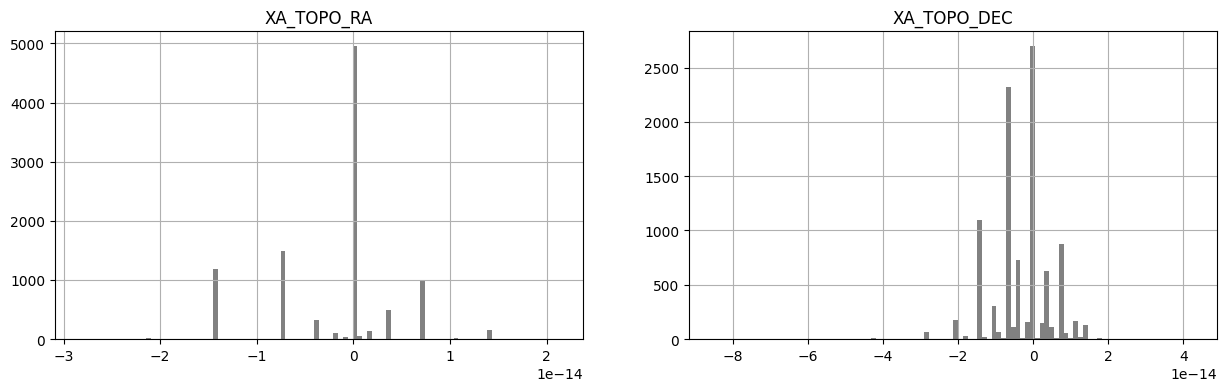

In [13]:
plt.close('all')
f,ax = plt.subplots(1,2,figsize=(15,4))
err = looks['ra'] - looks['XA_TOPO_RA']
err = err[ np.abs(err) < 10 ]
_ = ax[0].hist( err, bins=100, color='#818181') 
ax[0].set_title('XA_TOPO_RA')
_ = ax[1].hist( looks['dec'] - looks['XA_TOPO_DEC'], bins=100, color='#818181') 
ax[1].set_title('XA_TOPO_DEC')
for a in ax: a.grid()

In [28]:
looks['radot']

0       57.754679
1        7.141578
2       27.233319
3       58.298584
4       76.361034
          ...    
9995    86.930255
9996    47.345773
9997    50.261448
9998    47.425408
9999    44.621010
Name: radot, Length: 10000, dtype: float64

Text(0.5, 1.0, 'XA_TOPO_ELDOT')

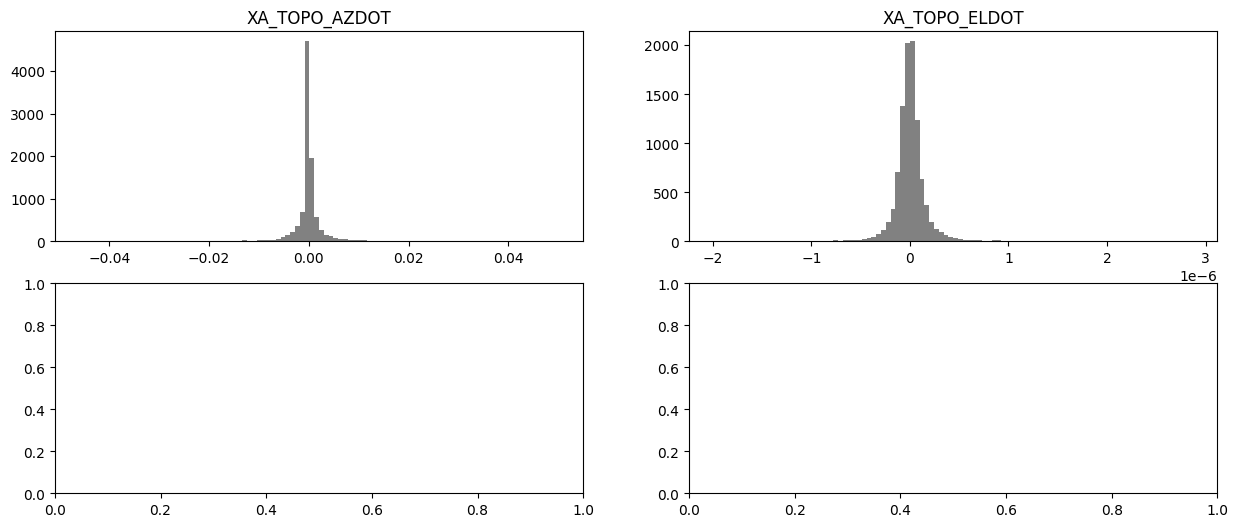

In [25]:
plt.close('all')
f,ax = plt.subplots(2,2,figsize=(15,6))
# avoid numbers like 359...
err = astropy_look.pm_az_cosalt.to_value(u.deg/u.s) - looks['XA_TOPO_AZDOT']
_ = ax[0,0].hist( err, bins=100, color='#818181') 
ax[0,0].set_title('XA_TOPO_AZDOT')
_ = ax[0,1].hist(astropy_look.pm_alt.to_value(u.deg/u.s) - looks['XA_TOPO_ELDOT'], bins=100, color='#818181') 
ax[0,1].set_title('XA_TOPO_ELDOT')


# _ = ax[2].hist( astropy_look.distance.to_value(u.km) - looks['XA_TOPO_RANGE'], bins=100, color='#818181') 
# ax[2].set_title('XA_TOPO_RANGE')
# for a in ax: a.grid()